# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Classroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

### 1).

In [2]:
class_names = ['mountain','street','glacier', 'buildings','sea','forest']

IMAGE_SIZE = (32,32)

In [3]:
class_names_label = {class_name:i for i ,class_name in enumerate(class_names)}
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [4]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "\\Prof\\seg_train (1)\\" 
TEST_PATH = ROOT_PATH + "\\Prof\\seg_test (1)\\seg_test\\"

In [5]:
def read_data(path, im_size, class_names_label):
    X = []
    y = []
    for folder in os.listdir(path):
        label = class_names_label[folder]
        folder_path = os.path.join(path,folder)
        # Iterar sobre todo lo que haya en path
        for file in os.listdir(folder_path):
            
            image_path = os.path.join(folder_path,file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, im_size) # Ya lo aplicó el resize
            
            X.append(image)
            y.append(label)
            
    return np.array(X), np.array(y)

X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE, class_names_label)
X_test, y_test = read_data(TEST_PATH, IMAGE_SIZE, class_names_label)

print(X_train.shape)
print(X_test.shape)

(14034, 32, 32, 3)
(3000, 32, 32, 3)


### 2).

(32, 32, 3)


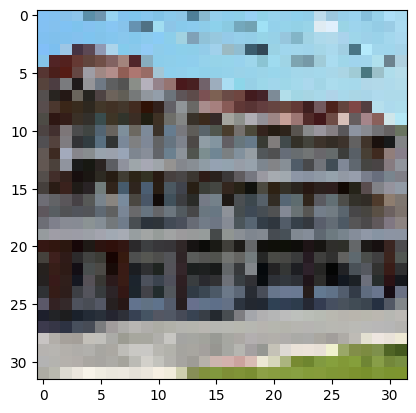

In [6]:
print(X_train[2].shape)
plt.imshow(X_train[2]);

### 3).

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


### 4).

In [8]:
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Definir el tamaño de la imagen
IMAGE_SIZE = (32, 32, 3)  

# Definir el modelo
layers = [
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(256, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),  # Reducir la tasa de Dropout
    keras.layers.Dense(6, activation='softmax')
]

model = keras.Sequential(layers)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Entrenar el modelo con EarlyStopping
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/20
351/351 [==============================] - 153s 420ms/step - loss: 1.1526 - accuracy: 0.5366 - val_loss: 0.8904 - val_accuracy: 0.6687
Epoch 2/20
351/351 [==============================] - 146s 416ms/step - loss: 0.8679 - accuracy: 0.6728 - val_loss: 0.8036 - val_accuracy: 0.6958
Epoch 3/20
351/351 [==============================] - 147s 419ms/step - loss: 0.7478 - accuracy: 0.7284 - val_loss: 0.7295 - val_accuracy: 0.7342
Epoch 4/20
351/351 [==============================] - 132s 376ms/step - loss: 0.6828 - accuracy: 0.7541 - val_loss: 0.7310 - val_accuracy: 0.7317
Epoch 5/20
351/351 [==============================] - 132s 375ms/step - loss: 0.6440 - accuracy: 0.7676 - val_loss: 0.6664 - val_accuracy: 0.7624
Epoch 6/20
351/351 [==============================] - 132s 375ms/step - loss: 0.5928 - accuracy: 0.7878 - val_loss: 0.6729 - val_accuracy: 0.7585
Epoch 7/20
351/351 [==============================] - 132s 375ms/step - loss: 0.5572 - accuracy: 0.8056 - val_loss: 0.6694 -

### 6).

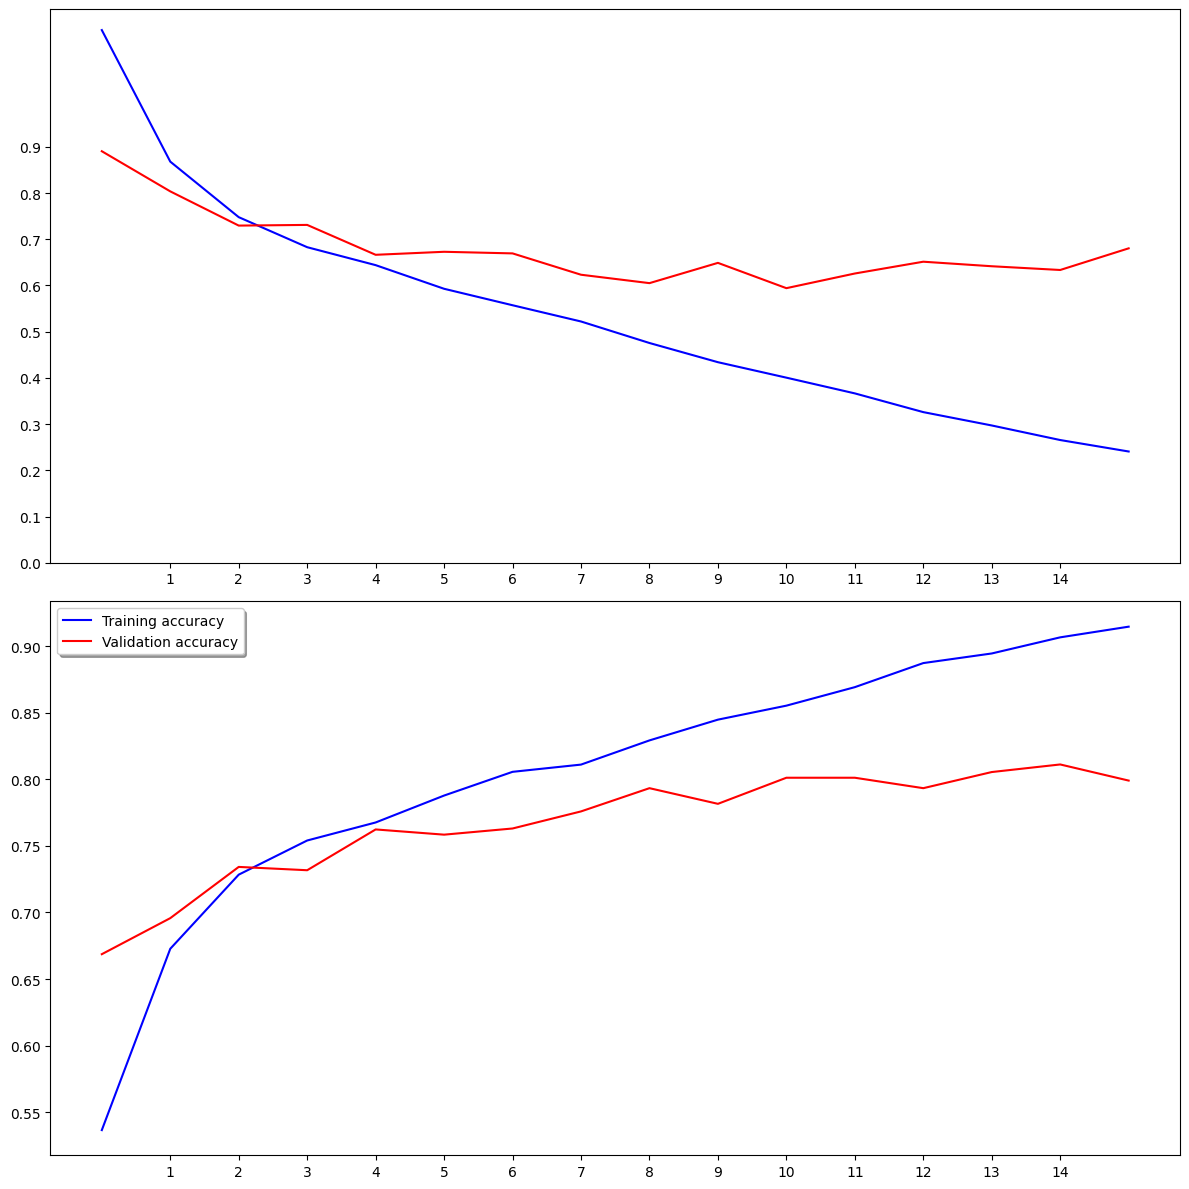

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 15, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 15, 1))

plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### 7).

In [10]:
results = model.evaluate(X_test, y_test)
results

94/94 [==============================] - 12s 123ms/step - loss: 0.5955 - accuracy: 0.7907


[0.5955459475517273, 0.7906666398048401]

### 9)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test).round(0))

94/94 [==============================] - 18s 185ms/step


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets